# Opposing Camera Setup: 3D Reconstruction and Calibration

## Overview

This code performs 3D reconstruction of an object with a known geometry—a 30x30 mm square—captured using an opposing camera setup. Using five key points from each of the left and right camera images (including the square's center), the 3D positions are calculated through triangulation. The results allow for calibration of the setup, refining the angles for better triangulation while addressing inherent inaccuracies.

---

## Steps in the Code

### 1. Input Parameters
The initial parameters include:
- **Camera specifications**:
  - Focal length, pixel size, and teleconverter factor.
- **Object geometry and distances**:
  - Known dimensions (30 mm) and distances between the object and cameras.
- **Calibration data**:
  - Ruler measurements and pixel offsets for alignment.

### 2. Angle Calibration
The angles between rulers for the left and right cameras are computed:
- Ruler measurements are converted to millimeters using pixel scales.
- Pixel offsets are corrected for optical axis misalignment.
- The calibrated angle between the rulers is calculated with adjustments for known inaccuracies.

### 3. Camera Baseline and Parameters
- The **baseline** (distance between cameras) is calculated using the angle between the cameras and object distances.
- Intrinsic camera matrices (`K1`, `K2`) and extrinsic parameters (rotation matrix `R` and translation vector `t`) are defined for triangulation.

### 4. Camera and Optical Axis Visualization
- The left and right camera positions and their optical axes are plotted in 2D.
- The baseline and angles between optical axes are shown for an intuitive understanding of the setup.

### 5. 3D Reconstruction
- **Triangulation**: 
  - Corresponding points from the left and right images are used to reconstruct 3D coordinates via `cv2.triangulatePoints`.
- **Results**:
  - Reconstructed 3D points are displayed in tabular format.
  - Depths relative to the cameras are computed.

### 6. Visualization of 3D Points
- **3D Perspective View**:
  - The reconstructed points are plotted in 3D space.
- **Projections**:
  - XY, YZ, and XZ projections provide additional insights.
  - Distances between selected points are calculated and annotated in the XZ projection.

### 7. Disparity Calculation
- Disparities (differences in x-coordinates) between corresponding points in the left and right images are calculated.
- Key statistics (mean, minimum, and maximum disparities) are provided.

---

## Key Results
- Accurate 3D reconstruction of the object is achieved, considering setup inaccuracies.
- The **calibrated angle** refines triangulation, ensuring alignment with the geometry of the object.
- Visualizations validate the reconstructed points and the camera alignment.

---

## Applications
This code is useful for:
- **Calibrating opposing camera setups** for stereo vision and 3D reconstruction.
- **Improving triangulation accuracy** by addressing alignment and setup inaccuracies.
- **Analyzing geometric and depth data** from stereo images in research or industrial applications.

---

By refining angles and correcting setup inaccuracies, this code provides a foundation for precise 3D reconstruction in opposing camera systems.


In [2]:
import numpy as np

# Given data
pixel_size_mm = 0.017  # mm per pixel (0.017 mm)
teleconverter_factor = 2  # No teleconverter used
focal_length_mm = 105 # Sigma Ex
focal_distance_mm = 46.5 # mm (F-mount)
left_object_distance_mm = 950  # mm (left camera to object distance)
right_object_distance_mm = 950  # mm (right camera to object distance)


# Left side data
left_ruler_1_pixels = 389.005  # Pixels for 3 cm on Ruler 1 (Left)
left_ruler_2_pixels = 413  # Pixels for 3 cm on Ruler 2 (Left)
left_zero_offset_pixels = 97  # Difference between the zeros in pixels (Left)
object_length_mm = 30  # mm (Geodriehoek)

# Right side data
right_ruler_1_pixels = 389.005 # Pixels for 3 cm on Ruler 1 (Right)
right_ruler_2_pixels = 412.03  # Pixels for 3 cm on Ruler 2 (Right)
right_zero_offset_pixels = 58  # Difference between the zeros in pixels (Right)


def calculate_angle(ruler_1_pixels, ruler_2_pixels, zero_offset_pixels, object_length_mm, object_distance_mm, pixel_size_mm, distance_between_rulers_mm=65):
    
    # Calculate the scale (mm per pixel) for each ruler
    ruler_1_scale = object_length_mm / ruler_1_pixels  # mm/pixel for Ruler 1
    ruler_2_scale = object_length_mm / ruler_2_pixels  # mm/pixel for Ruler 2
    
 
    # Use the average scale to convert the offset
    average_scale = (ruler_1_scale + ruler_2_scale) / 2

    # Calculate the physical offset in millimeters using the average scale
    physical_offset_mm = zero_offset_pixels * average_scale  # Convert pixel offset to mm

    # Calculate the angle using arctan
    angle_radians = np.arctan(physical_offset_mm / distance_between_rulers_mm)
    angle_degrees = np.degrees(angle_radians)

    # Calculate the angle that is caused by the offset of the camera optic axis (256 
    offset_angle_radians = np.arctan(256*(ruler_1_scale-pixel_size_mm) / object_distance_mm)
    offset_angle_degrees = np.degrees(offset_angle_radians)
    
    # Calculate the real angle
    corrected_angle_degrees = angle_degrees - offset_angle_degrees + 0.4 # The adding of 0.4 angle is a calibration measure 
    
    return corrected_angle_degrees 



# Calculate for left side
left_angle_degrees = calculate_angle(
    left_ruler_1_pixels, left_ruler_2_pixels, left_zero_offset_pixels, object_length_mm, left_object_distance_mm, pixel_size_mm)

# Calculate for right side
right_angle_degrees = calculate_angle(
    right_ruler_1_pixels, right_ruler_2_pixels, right_zero_offset_pixels, object_length_mm, right_object_distance_mm, pixel_size_mm)





# Output results
print("Left Side:")
print(f"  Angle between rulers: {left_angle_degrees:.6f} degrees")

print("\nRight Side:")
print(f"  Angle between rulers: {right_angle_degrees:.6f} degrees")

Left Side:
  Angle between rulers: 5.847818 degrees

Right Side:
  Angle between rulers: 3.298770 degrees


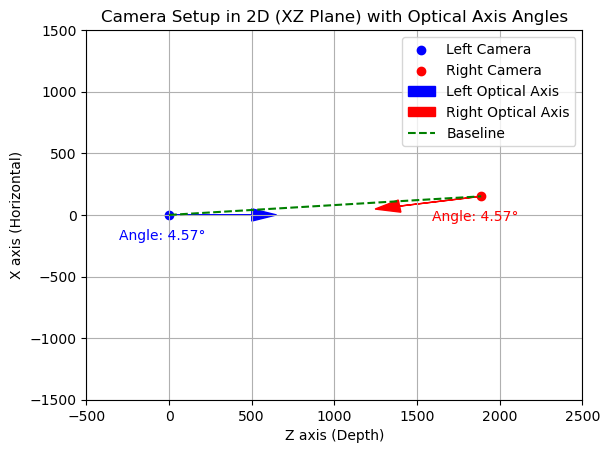

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt



# Step 1: Compute the angle between cameras
angle_between_cameras_degrees = 180. + left_angle_degrees + right_angle_degrees


# Step 2: Calculate the effective focal length with the teleconverter for both cameras
effective_focal_length_mm_left = teleconverter_factor * focal_length_mm
effective_focal_length_mm_right = teleconverter_factor * focal_length_mm

focal_length_pixels_left = effective_focal_length_mm_left / pixel_size_mm
focal_length_pixels_right = effective_focal_length_mm_right / pixel_size_mm

# Step 3: Compute the baseline (distance between cameras)
angle_between_cameras_radians = math.radians(angle_between_cameras_degrees)
baseline_mm = 2 * ((left_object_distance_mm + right_object_distance_mm) / 2) * math.sin(angle_between_cameras_radians / 2)
baseline_pixels = baseline_mm / pixel_size_mm


# Calibration matrices for left and right cameras
c_x_left = 256  
c_x_right = 256
c_y = 512

K1 = np.array([[focal_length_pixels_left, 0, c_x_left],
               [0, focal_length_pixels_left, c_y],
               [0, 0, 1]])

K2 = np.array([[focal_length_pixels_right, 0, c_x_right],
               [0, focal_length_pixels_right, c_y],
               [0, 0, 1]])

# Update the translation vector t to reflect the correct baseline
# t_x aligns with the baseline, t_z aligns with the depth
t_x = -baseline_mm * math.cos(angle_between_cameras_radians / 2)
t_z = baseline_mm * math.sin(angle_between_cameras_radians / 2)

t = np.array([t_x, 0, t_z])

# Skew-symmetric matrix [t]_x
t_skew = np.array([
    [0, -t[2], t[1]],
    [t[2], 0, -t[0]],
    [-t[1], t[0], 0]
])


theta = angle_between_cameras_radians
# Rotation matrix R (around Y-axis)
R = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
])



# Left camera is at the origin
left_camera_position = np.array([0, 0, 0])

# Right camera position is given by the translation vector t
right_camera_position_new = t

# Optical axes (assuming initial optical axes point along the Z-axis)
left_optical_axis = np.array([0, 0, 1])
right_optical_axis_new = np.dot(R, left_optical_axis)

# Compute angle between the baseline and the optical axes
left_optical_angle = np.degrees(np.arccos(np.dot(left_optical_axis[:2], np.array([1, 0]))))
right_optical_angle = np.degrees(np.arccos(np.dot(right_optical_axis_new[:2], np.array([1, 0]))))

# Plot the camera positions
fig, ax = plt.subplots()
ax.scatter(left_camera_position[2], left_camera_position[0], color='blue', label='Left Camera')
ax.scatter(right_camera_position_new[2], right_camera_position_new[0], color='red', label='Right Camera')

# Plot the optical axes as arrows
ax.arrow(left_camera_position[2], left_camera_position[0], left_optical_axis[2] * 500, left_optical_axis[0] * 500,
         color='blue', head_width=100, label='Left Optical Axis')
ax.arrow(right_camera_position_new[2], right_camera_position_new[0], right_optical_axis_new[2] * 500,
         right_optical_axis_new[0] * 500, color='red', head_width=100, label='Right Optical Axis')

# Plot the baseline
ax.plot([left_camera_position[2], right_camera_position_new[2]],
        [left_camera_position[0], right_camera_position_new[0]],
        color='green', linestyle='--', label='Baseline')

# Display the angles
ax.text(left_camera_position[2] - 300, left_camera_position[0] - 200,
        f'Angle: {(left_angle_degrees+right_angle_degrees)/2:.2f}°', color='blue')
ax.text(right_camera_position_new[2] - 300, right_camera_position_new[0] - 200,
        f'Angle: {(left_angle_degrees+right_angle_degrees)/2:.2f}°', color='red')

# Labels and limits
ax.set_xlabel('Z axis (Depth)')
ax.set_ylabel('X axis (Horizontal)')
ax.set_xlim([-500, 2500])
ax.set_ylim([-1500, 1500])
ax.legend()
ax.set_title('Camera Setup in 2D (XZ Plane) with Optical Axis Angles')

plt.grid(True)
plt.show()



In [4]:

# Consider the coordinates as two images
# Left image coordinates (1 to 5)
left_coordinates = [
    (32, 373),  # Coordinate 1
    (74, 374),  # Coordinate 2
    (248, 372),  # Coordinate 3 
    (413, 371),  # Coordinate 4
    (470, 370)   # Coordinate 5
]


# Right image coordinates (6 to 10)
right_coordinates = [
    (1023-512, 373),  # Coordinate 10
    (909-512, 375),   # Coordinate 9
    (779-512, 372),   # Coordinate 8
    (646-512, 371),   # Coordinate 7
    (537-512, 373)    # Coordinate 6
]


# Combine into matching pairs
matching_pairs_original = list(zip(left_coordinates, right_coordinates))


Computed 3D Points:
       X (mm)     Y (mm)      Z (mm)
0  17.483452  10.706352  963.337708
1  13.746306  10.584771  934.226990
2   0.618408  10.767329  951.459412
3 -12.269928  10.833761  968.198364
4 -16.252520  10.788291  938.113770


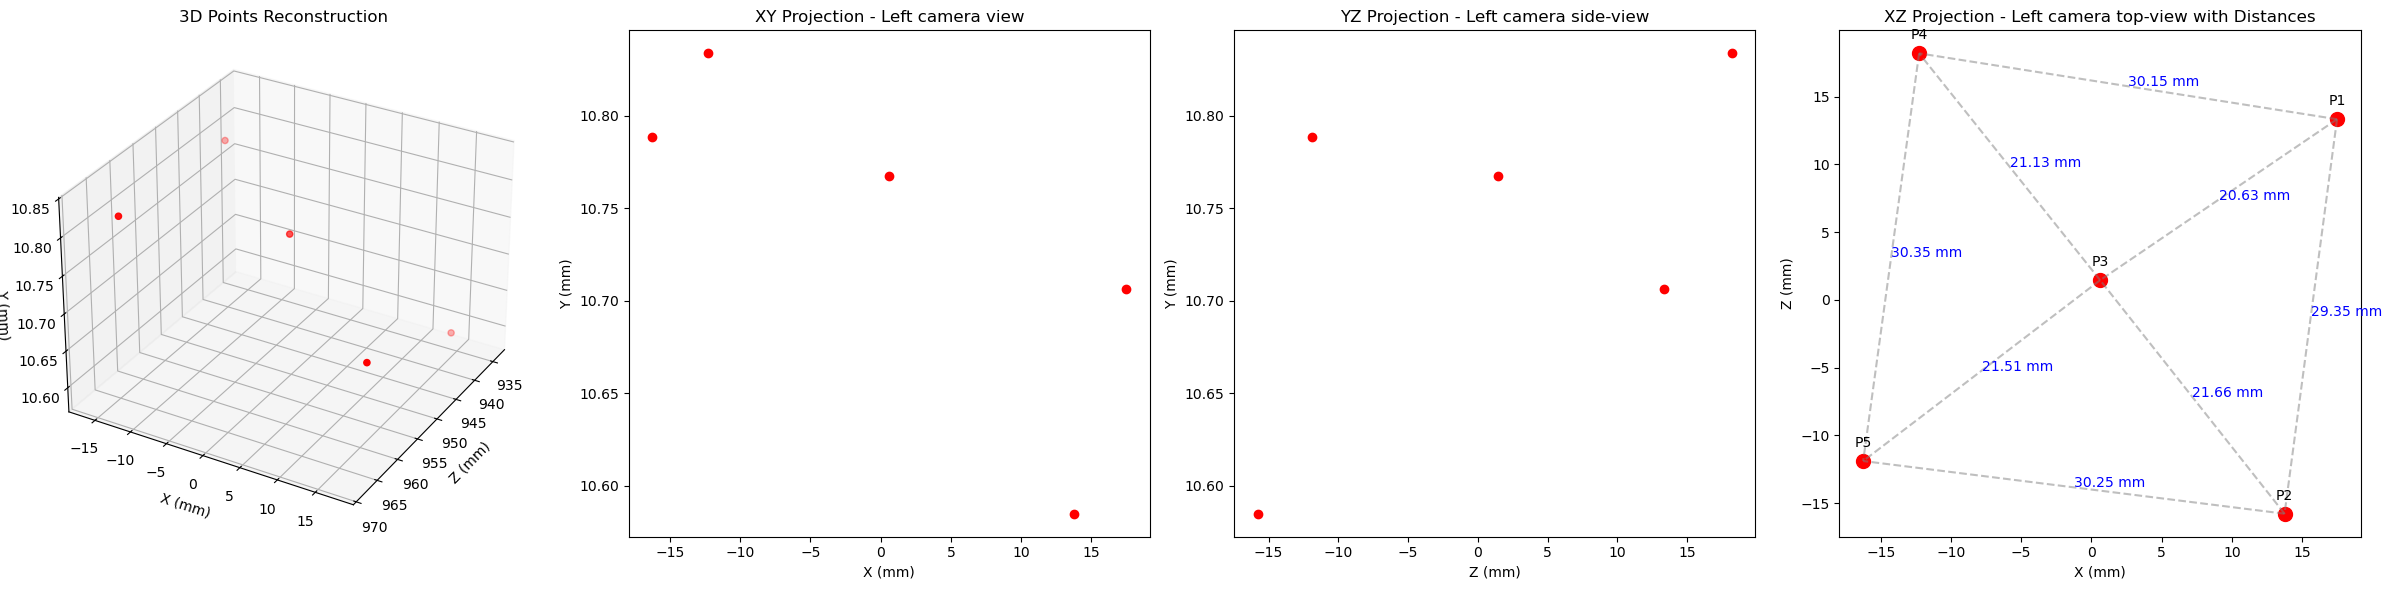

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Convert coordinates to graph-like system (origin at bottom-left)
def convert_to_graph_coordinates(point, img_height):
    x, y = point
    return (x, img_height - y)

# Adjust the best matching pairs to graph coordinates
img_height = 1024
matching_pairs_original = [(convert_to_graph_coordinates(left_pt, img_height), convert_to_graph_coordinates(right_pt, img_height)) for left_pt, right_pt in matching_pairs_original]



# Convert coordinates to graph-like system (origin at bottom-left)
def mirror_coordinates(point, img_width):
    x, y = point
    return (img_width-x,  y)

# Adjust the best matching pairs to graph coordinates
img_width = 512

matching_pairs = [(mirror_coordinates(left_pt, img_width), mirror_coordinates(right_pt, img_width)) for left_pt, right_pt in matching_pairs_original]

# Visualize the best matching pairs in the new coordinate system

# Reconstruct the 3D points using triangulation
def triangulate_points(K1, K2, R, t, matching_pairs):
    P1 = np.dot(K1, np.hstack((np.eye(3), np.zeros((3, 1)))))
    P2 = np.dot(K2, np.hstack((R, t.reshape(-1, 1))))
    
    pts1 = np.array([pt[0] for pt in matching_pairs], dtype=np.float32)
    pts2 = np.array([pt[1] for pt in matching_pairs], dtype=np.float32)
    
    points4D_homogeneous = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    points3D = points4D_homogeneous / points4D_homogeneous[3]
    points3D = points3D[:3].T
    
    return points3D

# Calculate the 3D points
points3D = triangulate_points(K1, K2, R, t, matching_pairs)

# Convert to a DataFrame for better visualization
points3D_df = pd.DataFrame(points3D, columns=['X (mm)', 'Y (mm)', 'Z (mm)'])
print("Computed 3D Points:\n", points3D_df)




# Compute depths separately for the left and right images
depths_left = points3D[:, 2] - left_object_distance_mm  # Adjusting with left camera object distance
depths_right = np.dot(R[2, :], points3D.T).T + t[2] - right_object_distance_mm  # Adjusting for right camera's position


# Create a figure with subplots
fig = plt.figure(figsize=(24, 6))

# 3D plot with swapped axes
ax1 = fig.add_subplot(141, projection='3d')
ax1.scatter(points3D[:, 2], points3D[:, 0], points3D[:, 1], c='r', marker='o')
ax1.set_xlabel('Z (mm)')
ax1.set_ylabel('X (mm)')
ax1.set_zlabel('Y (mm)')
ax1.view_init(elev=30, azim=30)
ax1.set_title('3D Points Reconstruction')

# XY projection (ignoring Z)
ax2 = fig.add_subplot(142)
ax2.scatter(points3D[:, 0], points3D[:, 1], c='r', marker='o')
ax2.set_xlabel('X (mm)')
ax2.set_ylabel('Y (mm)')
ax2.set_title('XY Projection - Left camera view')

# YZ projection (ignoring X)
ax4 = fig.add_subplot(143)
ax4.scatter(points3D[:, 2]-left_object_distance_mm, points3D[:, 1], c='r', marker='o')
ax4.set_xlabel('Z (mm)')
ax4.set_ylabel('Y (mm)')
ax4.set_title('YZ Projection - Left camera side-view')

# XZ projection (ignoring Y)
ax3 = fig.add_subplot(144)

# Subtract the object distance from the Z-coordinates
adjusted_points3D = points3D.copy()
adjusted_points3D[:, 2] -= left_object_distance_mm

for i in range(len(points3D)):
    ax3.scatter(adjusted_points3D[i, 0], adjusted_points3D[i, 2], color='red', s=100)
    ax3.annotate(f'P{i+1}', (adjusted_points3D[i, 0], adjusted_points3D[i, 2]), textcoords="offset points", xytext=(0,10), ha='center')

# Exclude distances between P1-P5 and P2-P4
exclude_pairs = [(0, 4), (1, 3)]  # Indices of points P1-P5 and P2-P4

for i in range(len(points3D)):
    for j in range(i + 1, len(points3D)):
        if (i, j) not in exclude_pairs:
            # Draw lines between points and annotate the distances
            distance = np.linalg.norm(adjusted_points3D[i, [0, 2]] - adjusted_points3D[j, [0, 2]])
            midpoint = (adjusted_points3D[i, 0] + adjusted_points3D[j, 0]) / 2, (adjusted_points3D[i, 2] + adjusted_points3D[j, 2]) / 2
            ax3.plot([adjusted_points3D[i, 0], adjusted_points3D[j, 0]], [adjusted_points3D[i, 2], adjusted_points3D[j, 2]], 'gray', linestyle='--', alpha=0.5)
            ax3.annotate(f'{distance:.2f} mm', midpoint, color='blue')

ax3.set_xlabel('X (mm)')
ax3.set_ylabel('Z (mm)')
ax3.set_title('XZ Projection - Left camera top-view with Distances')

# Show the plots
plt.tight_layout()
plt.show()

In [6]:
def compute_disparities(pts1, pts2):
    """Calculate the disparity for each corresponding point."""
    x1 = pts1[:, 0]  # x-coordinates from the first image
    x2 = pts2[:, 0]  # x-coordinates from the second image
    disparity = x1 - x2  # disparity is the difference in x-coordinates
    return disparity

# Calculate the 2D points for disparity
pts1 = np.array([pt[0] for pt in matching_pairs], dtype=np.float32)
pts2 = np.array([pt[1] for pt in matching_pairs], dtype=np.float32)

# Compute disparity values
disparities = compute_disparities(pts1, 512-pts2)

# Display some key information
print(f"Disparities (first 5 values): {disparities[:5]}")
print(f"Mean disparity: {np.mean(disparities):.4f}")
print(f"Min disparity: {np.min(disparities):.4f}")
print(f"Max disparity: {np.max(disparities):.4f}")

Disparities (first 5 values): [-31.  41.  -3. -35.  17.]
Mean disparity: -2.2000
Min disparity: -35.0000
Max disparity: 41.0000
